In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import LogNormalAFTFitter

In [30]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter

In [31]:
data = pd.read_csv("telco.csv")
data.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


## Data Preprocessing

In [32]:
#Getting rid of 0 values and making dummy variables
data['churn'] = data['churn'].map({'Yes': 1, 'No': 0})

encode_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']

data2 = pd.get_dummies(data,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=True)

data2["tenure"] = np.where(data2["tenure"] == 0, 0.0000001, data2["tenure"])

## Building AFT Model

In [33]:
#Creating instances for each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

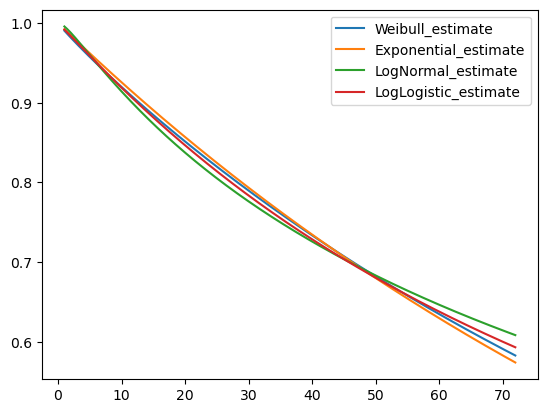

In [34]:
#Plotting to understand which one is better
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data["tenure"], event_observed = data["churn"])
    model.plot_survival_function(ci_show=False)

In [35]:
#Making a test to understand which one is better
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data2["tenure"], event_observed =data2["churn"])
    # Print AIC to understand which model is performing better. The smaller the AIC the better.
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 3216.8611706815464
The AIC value for ExponentialFitter is 3215.9608134637247
The AIC value for LogNormalFitter is 3209.0351474316735
The AIC value for LogLogisticFitter is 3214.4154757933375


We can see that LogNormalFitter has the lowest AIC value. So, we will choose that one

In [36]:
#Making the model
lnf = LogNormalAFTFitter()
lnf.fit(data2, duration_col='tenure', event_col='churn')
lnf.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1454.15
         time fit was run = 2024-05-01 19:53:22 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    ID                               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.06       2.90       0.17             0.73             1.40                 2.08                 4.04
       custcat_Plus service              0.94       2.55       0.22             0.52             1.36                 1.68                 3.89
       custcat_Total service             1.21       3.35       0.25             0.72             1.70                 2.06                 5.47
       ed_Did not complete high school   0.38       1.46       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.31       1.36       0.16            -0.01             0.62                 0.99                 1.87
       ed_Post-undergraduate degree     -0.05       0.95       0.22            -0.49             0.38                 0.61                 1.46
       ed_Some college                   0.29       1.33       0.16            -0.04             0.61                 0.96                 1.84
       forward_Yes                      -0.20       0.82       0.18            -0.56             0.15                 0.57                 1.16
       gender_Male                       0.04       1.04       0.11            -0.19             0.26                 0.83                 1.30
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.79       0.45       0.14            -1.07            -0.51                 0.34                 0.60
       marital_Unmarried                -0.44       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       region_Zone 2                    -0.09       0.91       0.14            -0.37             0.18                 0.69                 1.20
       region_Zone 3                     0.06       1.06       0.14            -0.22             0.34                 0.81                 1.40
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.41       0.66       0.17            -0.74            -0.08                 0.48                 0.92
       Intercept                         2.57      13.09       0.30             1.97             3.17                 7.20                23.78
sigma_ Intercept                         0.27       1.31       0.05             0.18             0.36                 1.20                 1.43

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    ID                                  0.00 -2.39   0.02       5.89
       address                             0.00  4.80 <0.005      19.27
       age                                 0.00  4.59 <0.005      

We can see that, according to p-values, the significant features are address, age, custcat_E-service, custcat_Plus service, custcat_Total service, internet_Yes, marital_Unmarried, voice_Yes. So we will keep that ones.

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.10
         time fit was run = 2024-05-01 19:54:17 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    address                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service       1.03       2.79       0.17             0.69             1.36                 2.00                 3.89
       custcat_Plus service    0.82       2.28       0.17             0.49             1.15                 1.63                 3.17
       custcat_Total service   1.01       2.75       0.21             0.60             1.42                 1.83                 4.15
       internet_Yes           -0.84       0.43       0.14            -1.11            -0.57                 0.33                 0.57
       marital_Unmarried      -0.45       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       voice_Yes              -0.46       0.63       0.17            -0.79            -0.14                 0.45                 0.87
       Intercept               2.53      12.62       0.24             2.06             3.01                 7.84                20.30
sigma_ Intercept               0.28       1.33       0.05             0.19             0.37                 1.21                 1.45

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    address                   0.00  4.84 <0.005      19.56
       age                       0.00  5.75 <0.005      26.78
       custcat_E-service         0.00  6.07 <0.005      29.53
       custcat_Plus service      0.00  4.85 <0.005      19.66
       custcat_Total service     0.00  4.83 <0.005      19.52
       internet_Yes              0.00 -6.08 <0.005      29.63
       marital_Unmarried         0.00 -3.91 <0.005      13.39
       voice_Yes                 0.00 -2.78   0.01       7.52
       Intercept                 0.00 10.45 <0.005      82.47
sigma_ Intercept                 0.00  6.15 <0.005      30.27
---
Concordance = 0.79
AIC = 2944.20
log-likelihood ratio test = 280.83 on 8 df
-log2(p) of ll-ratio test = 183.73

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

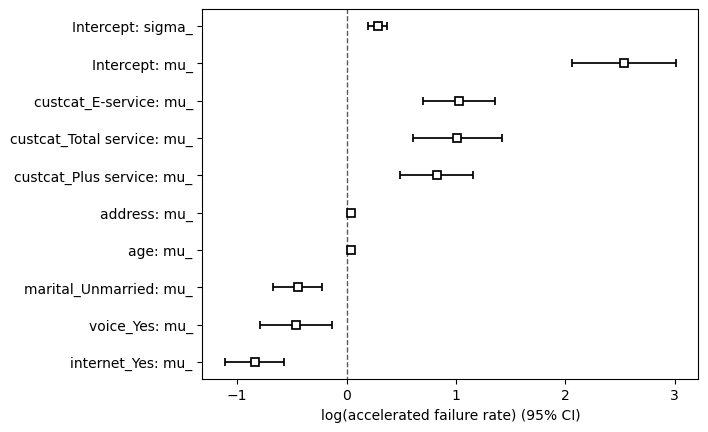

In [37]:
#Choosing only significant features
data2 = data2[["tenure", "churn", "address", "age", "custcat_E-service", "custcat_Plus service", "custcat_Total service", "internet_Yes", "marital_Unmarried", "voice_Yes"]]
lnf.fit(data2, duration_col='tenure', event_col='churn')
lnf.print_summary()
lnf.plot()

We can see that AIC decreased. So, we can conclude that the model selection worked

## Calculating CLV

In [38]:
#Choosing data for only 1 year
pred = lnf.predict_survival_function(data2)[:12]

In [39]:
#Calculating model for each person and adding as new column
monthly_margin = 1200 #assumption
pred = pred*monthly_margin
rate  = 0.3 
pred = pd.DataFrame({col: [pred.iloc[row-1, col-1] / (1 + rate)**(row-1) for row in range(1, 13)] for col in range(1, len(pred.columns)+1)})

In [40]:
data["CLV"] = pred[12]

C:\Users\user\AppData\Local\Temp\ipykernel_8308\2611369159.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  clv_ed = sns.displot(data, x = 'CLV', kind = 'kde', hue = 'ed')
C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


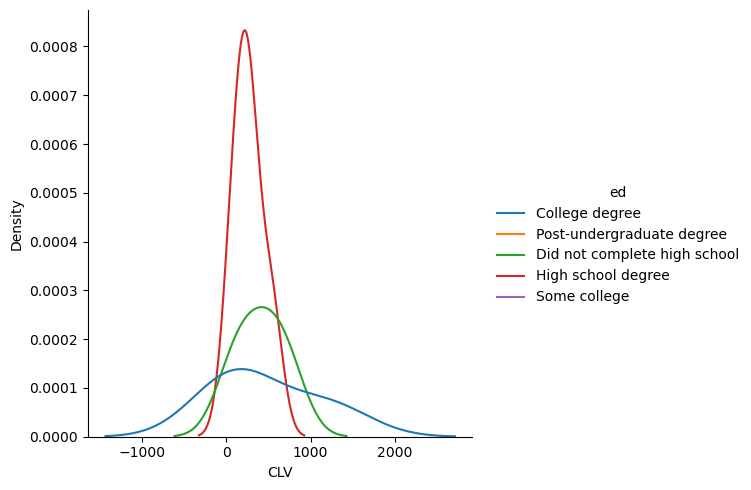

In [41]:
clv_ed = sns.displot(data, x = 'CLV', kind = 'kde', hue = 'ed')
clv_martial.set(title='Customer Lifetime Value by EDucation')

We can see that people that who have college degree are the most likely to survive longer

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


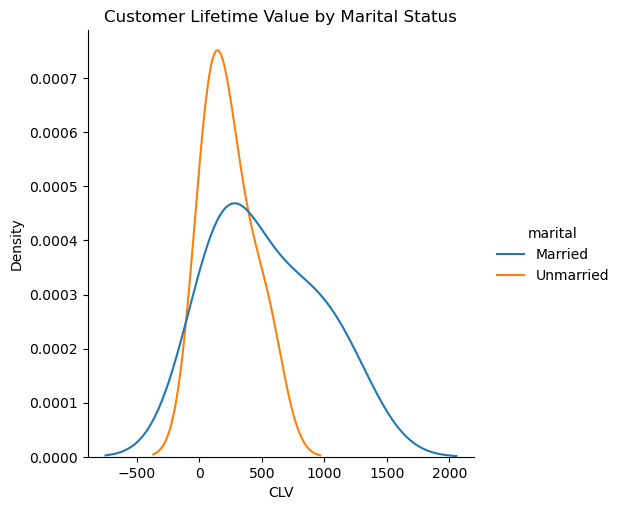

In [42]:
clv_martial = sns.displot(data, x = 'CLV', kind = 'kde', hue = 'marital')
clv_martial.set(title='Customer Lifetime Value by Marital Status')

We can see that married people are more likely to survive longer

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


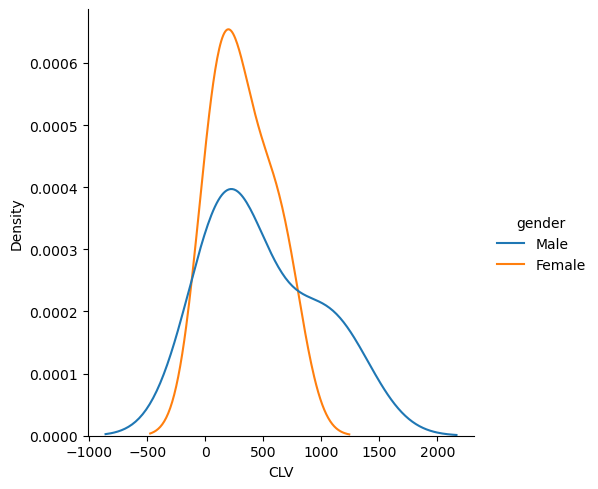

In [43]:
clv_gender = sns.displot(data, x = 'CLV', kind = 'kde', hue = 'gender')
clv_martial.set(title='Customer Lifetime Value by Gender')

We can see that men are more likely to survive longer than women

## Report

The analysis we did above was made to understand factors influencing churn risk in a telecom company. We chose Log-Normal Accelerated Failure Time (AFT) model, which provided good results. We saw that significant features affecting churn risk include customer address, age, education level, service type, internet subscription, marital status, and voice service. Interpretation of coefficients shows that higher values in address, age, and specific service types correlate with decreased churn risk, while unmarried individuals and those without internet or voice services have higher churn risk.

For us, the valuable customers could be the ones with high CLV and low churn risk. From the graphs above, we can conclude that the most valuable segment are married men with college degree.

In [44]:
#Determining the annual retention budget

sum_clv =  np.sum(data['CLV'])
print(sum_clv)

4899.390736022806


For retention, I would suggest implementing personalized communication strategies, offering loyalty rewards. We can make special offers for valuable customers to further reduce the churn rates. Additionally, we can conduct regular customer feedback surveys and monitor competitor offerings, which can help to understand where we can improve and get more profit.